In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import pdb
from tqdm import tqdm
import pandas as pd
import pickle
import io
import os
import sacrebleu
import math

from torch.autograd import Variable
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
PAD_idx = 0
SOS_idx = 1
EOS_idx = 2
UNK_idx= 3
batch_size = 64
MAX_SENTENCE_LENGTH = 40

In [3]:
en_pretrained_path = './wiki-news-300d-1M.vec'
zh_pretrained_path = './cc.vi.300.vec'
data_prefix = './'

## Read Data

In [4]:
train_en = open('iwslt-vi-en/train.tok.en' , encoding='utf-8').read().strip().split('\n')
val_en = open('iwslt-vi-en/dev.tok.en', encoding='utf-8').read().strip().split('\n')
test_en = open('iwslt-vi-en/test.tok.en', encoding='utf-8').read().strip().split('\n')
train_en[:10]

['Rachel Pike : The science behind a climate headline',
 'In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .',
 'I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
 'Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .',
 'They are both two branches of the same field of atmospheric science .',
 'Recently the headlines looked like this when the Intergovernmental Panel on Climate Change , or IPCC , put out their report on the state of understanding of the atmospheric system .',
 'That report was written by 620 scientists from 40 countries .',
 'They wrote almost a thousand pages

['Rachel Pike : The science behind a climate headline',
 'In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .',
 'I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
 'Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .',
 'They are both two branches of the same field of atmospheric science .',
 'Recently the headlines looked like this when the Intergovernmental Panel on Climate Change , or IPCC , put out their report on the state of understanding of the atmospheric system .',
 'That report was written by 620 scientists from 40 countries .',
 'They wrote almost a thousand pages

In [5]:
train_zh = open('iwslt-vi-en/train.tok.vi', encoding='utf-8').read().strip().split('\n')
val_zh = open('iwslt-vi-en/dev.tok.vi', encoding='utf-8').read().strip().split('\n')
test_zh = open('iwslt-vi-en/test.tok.vi', encoding='utf-8').read().strip().split('\n')

train_zh[:10]

['Khoa_học đằng_sau một tiêu_đề về khí_hậu',
 'Trong 4 phút , chuyên_gia hoá_học khí_quyển Rachel Pike giới_thiệu sơ_lược về những nỗ_lực khoa_học miệt_mài đằng_sau những tiêu_đề táo_bạo về biến_đổi khí_hậu , cùng với đoàn nghiên_cứu của mình - - hàng ngàn người đã cống_hiến cho dự_án này - - một chuyến bay mạo_hiểm qua rừng_già để tìm_kiếm thông_tin về một phân_tử then_chốt .',
 'Tôi muốn cho các bạn biết về sự to_lớn của những nỗ_lực khoa_học đã góp_phần làm_nên các dòng tít bạn thường thấy trên báo .',
 'Có những dòng trông như thế_này khi bàn về biến_đổi khí_hậu , và như thế_này khi nói về chất_lượng không_khí hay khói bụi .',
 'Cả hai đều là một nhánh của cùng một lĩnh_vực trong ngành khoa_học khí_quyển .',
 'Các tiêu_đề gần_đây trông như thế_này khi Ban Điều_hành Biến_đổi khí_hậu Liên_chính_phủ , gọi tắt là IPCC đưa ra_bài nghiên_cứu của họ về hệ_thống khí_quyển .',
 'Nghiên_cứu được viết bởi 620 nhà khoa_học từ 40 quốc_gia khác nhau .',
 'Họ viết gần 1000 trang về chủ_đề này .',

['Khoa_học đằng_sau một tiêu_đề về khí_hậu',
 'Trong 4 phút , chuyên_gia hoá_học khí_quyển Rachel Pike giới_thiệu sơ_lược về những nỗ_lực khoa_học miệt_mài đằng_sau những tiêu_đề táo_bạo về biến_đổi khí_hậu , cùng với đoàn nghiên_cứu của mình - - hàng ngàn người đã cống_hiến cho dự_án này - - một chuyến bay mạo_hiểm qua rừng_già để tìm_kiếm thông_tin về một phân_tử then_chốt .',
 'Tôi muốn cho các bạn biết về sự to_lớn của những nỗ_lực khoa_học đã góp_phần làm_nên các dòng tít bạn thường thấy trên báo .',
 'Có những dòng trông như thế_này khi bàn về biến_đổi khí_hậu , và như thế_này khi nói về chất_lượng không_khí hay khói bụi .',
 'Cả hai đều là một nhánh của cùng một lĩnh_vực trong ngành khoa_học khí_quyển .',
 'Các tiêu_đề gần_đây trông như thế_này khi Ban Điều_hành Biến_đổi khí_hậu Liên_chính_phủ , gọi tắt là IPCC đưa ra_bài nghiên_cứu của họ về hệ_thống khí_quyển .',
 'Nghiên_cứu được viết bởi 620 nhà khoa_học từ 40 quốc_gia khác nhau .',
 'Họ viết gần 1000 trang về chủ_đề này .',

In [6]:
print ('Length of train data:', len(train_en))
print ('Length of val data:', len(val_en))
print ('Length of test data:', len(test_en))

Length of train data: 133317
Length of val data: 1268
Length of test data: 1553
Length of train data: 133317
Length of val data: 1268
Length of test data: 1553


In [7]:
def to_dataframe(en, ch, len_raio=0.8):
    en_len_list, ch_len_list = [], []
    for en_sample, ch_sample in zip(en, ch):
        en_len_list.append(len(en_sample))
        ch_len_list.append(len(ch_sample))
    df = pd.DataFrame({'en': en, 
                       'en_len': en_len_list,
                       'ch': ch,
                       'ch_len': ch_len_list
                      })
    en_len_at_ratio = sorted(en_len_list)[int(len_raio*len(en_len_list))]
    ch_len_at_ratio = sorted(ch_len_list)[int(len_raio*len(ch_len_list))]
    print ("EN length @{}: {}, CH length @{}: {}".format(len_raio, en_len_at_ratio, len_raio, ch_len_at_ratio))
    return df, max(en_len_at_ratio, ch_len_at_ratio)

## Data Preprocessing 



load pre-trained embedding and create the index2words

In [8]:
# Get the vocabulary based on the training data
from collections import Counter

def get_vocabulary(data, VOCABULARY_SIZE=10000):
    en_vocab, ch_vocab = [], []
    for idx, row in data.iterrows():
        en_vocab += row['en'].split()
        ch_vocab += row['ch'].split()
    en_token_counter = Counter(en_vocab)
    ch_token_counter = Counter(ch_vocab)
    print ("Number of en words: {}, ch words: {}".format(len(en_token_counter), len(ch_token_counter)))
    en_word, _ = zip(*en_token_counter.most_common(VOCABULARY_SIZE))
    en_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(en_word)
    en_token2id = dict(zip(en_id2token, np.arange(len(en_id2token))))
    ch_word, _ = zip(*ch_token_counter.most_common(VOCABULARY_SIZE))
    ch_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(ch_word)
    ch_token2id = dict(zip(ch_id2token, np.arange(len(ch_id2token))))
    return en_id2token, en_token2id, ch_id2token, ch_token2id


In [9]:
def load_vectors(fname):
    """
    load the pretrained word embeddings
    param fname: the path the to the word embedding
    return: 
            a dictionary of the {word: embedding}
    """
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [10]:
def load_pickle(data_path, callback, *callback_args):
    """
    Create huge file with the callback function if not exist, otherwise load directly
    param data_path: the path of the load file if exist, otherwise the path to store the created file
    param callback: the function to generate the data if not exist
    param callback_args: the argument for the callback:
    return: 
            the data, either loaded or created by callback
    """

    data_path = data_prefix+data_path
    if os.path.isfile(data_path):
        print ('File exists, load from path...')
        data = pickle.load(open(data_path, 'rb'))
    else:
        print ('File not exists, creating...')
        data = callback(*callback_args)
        pickle.dump(data, open(data_path, 'wb'))
    return data

In [11]:
def get_embedding_weights(whole_vec, id2token):
    """
    get the embeddings based on the word, create the embedding matrix
    param whole_vec: the dictionary of pretrained embeddings
    param id2token: the whole vocabulary
    return:
            embedding matrix
    """
    weight = np.zeros((len(id2token), len(whole_vec['sky'])))
    mask = np.zeros((len(id2token)))
    for i, word in enumerate(id2token[1:]):
        if word in whole_vec.keys():
            weight[i+1] = np.array(whole_vec[word])
        else:
            weight[i+1] = np.array(whole_vec['UNK'])
            mask[i+1] = 1
            print ("Out of vocabulary word: ", word)   
    return weight, mask

Normalize english sentences

In [12]:
#Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s = s.strip()
    return s

def normalizeZh(s):
    #s = s.decode("utf8")
    #s = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）％]+", " ",s)
    s = re.sub( '\s+', ' ', s )
    s = s.strip()
    return s

def normalizeVi(s):
    s = s.lower().strip()
    s =re.sub(r"[-()\"#/@;:<>{}`+=~|,]", "", s)
    s = re.sub(r"[0-9]","",s)
    s = re.sub( '\s+', ' ', s)
    return s

Token to index function

In [13]:
def token_to_index(sentence, token2id):
    indicies_data = []
    for s in sentence:
        tokens = s.split(' ')
        index_list =[token2id[token] if token in token2id else UNK_idx for token in tokens]
        assert len(tokens) == len(index_list)
        indicies_data.append(index_list)
    return indicies_data


** English**


In [14]:
normalize_train_en = [normalizeString(s) for s in train_en]
normalize_val_en = [normalizeString(s) for s in val_en]
normalize_test_en = [normalizeString(s) for s in test_en]

In [15]:
normalize_train_en[:10]

['rachel pike the science behind a climate headline',
 'in minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule',
 'i apos d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper',
 'headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog',
 'they are both two branches of the same field of atmospheric science',
 'recently the headlines looked like this when the intergovernmental panel on climate change or ipcc put out their report on the state of understanding of the atmospheric system',
 'that report was written by scientists from countries',
 'they wrote almost a thousand pages on the topic',
 'and all of those pages

['rachel pike the science behind a climate headline',
 'in minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule',
 'i apos d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper',
 'headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog',
 'they are both two branches of the same field of atmospheric science',
 'recently the headlines looked like this when the intergovernmental panel on climate change or ipcc put out their report on the state of understanding of the atmospheric system',
 'that report was written by scientists from countries',
 'they wrote almost a thousand pages on the topic',
 'and all of those pages

** Vinamese**

In [16]:
normalize_train_zh = [normalizeVi(s) for s in train_zh]
normalize_val_zh = [normalizeVi(s) for s in val_zh]
normalize_test_zh = [normalizeVi(s) for s in test_zh]

In [17]:
normalize_train_zh[:10]

['khoa_học đằng_sau một tiêu_đề về khí_hậu',
 'trong phút chuyên_gia hoá_học khí_quyển rachel pike giới_thiệu sơ_lược về những nỗ_lực khoa_học miệt_mài đằng_sau những tiêu_đề táo_bạo về biến_đổi khí_hậu cùng với đoàn nghiên_cứu của mình hàng ngàn người đã cống_hiến cho dự_án này một chuyến bay mạo_hiểm qua rừng_già để tìm_kiếm thông_tin về một phân_tử then_chốt .',
 'tôi muốn cho các bạn biết về sự to_lớn của những nỗ_lực khoa_học đã góp_phần làm_nên các dòng tít bạn thường thấy trên báo .',
 'có những dòng trông như thế_này khi bàn về biến_đổi khí_hậu và như thế_này khi nói về chất_lượng không_khí hay khói bụi .',
 'cả hai đều là một nhánh của cùng một lĩnh_vực trong ngành khoa_học khí_quyển .',
 'các tiêu_đề gần_đây trông như thế_này khi ban điều_hành biến_đổi khí_hậu liên_chính_phủ gọi tắt là ipcc đưa ra_bài nghiên_cứu của họ về hệ_thống khí_quyển .',
 'nghiên_cứu được viết bởi nhà khoa_học từ quốc_gia khác nhau .',
 'họ viết gần trang về chủ_đề này .',
 'và tất_cả các trang đều đượ

['khoa_học đằng_sau một tiêu_đề về khí_hậu',
 'trong phút chuyên_gia hoá_học khí_quyển rachel pike giới_thiệu sơ_lược về những nỗ_lực khoa_học miệt_mài đằng_sau những tiêu_đề táo_bạo về biến_đổi khí_hậu cùng với đoàn nghiên_cứu của mình hàng ngàn người đã cống_hiến cho dự_án này một chuyến bay mạo_hiểm qua rừng_già để tìm_kiếm thông_tin về một phân_tử then_chốt .',
 'tôi muốn cho các bạn biết về sự to_lớn của những nỗ_lực khoa_học đã góp_phần làm_nên các dòng tít bạn thường thấy trên báo .',
 'có những dòng trông như thế_này khi bàn về biến_đổi khí_hậu và như thế_này khi nói về chất_lượng không_khí hay khói bụi .',
 'cả hai đều là một nhánh của cùng một lĩnh_vực trong ngành khoa_học khí_quyển .',
 'các tiêu_đề gần_đây trông như thế_này khi ban điều_hành biến_đổi khí_hậu liên_chính_phủ gọi tắt là ipcc đưa ra_bài nghiên_cứu của họ về hệ_thống khí_quyển .',
 'nghiên_cứu được viết bởi nhà khoa_học từ quốc_gia khác nhau .',
 'họ viết gần trang về chủ_đề này .',
 'và tất_cả các trang đều đượ

In [18]:
train_df, pad_len = to_dataframe(normalize_train_en, normalize_train_zh)
val_df, _ = to_dataframe(normalize_val_en, normalize_val_zh)
test_df, _ = to_dataframe(normalize_test_en, normalize_test_zh)

EN length @0.8: 138, CH length @0.8: 141
EN length @0.8: 143, CH length @0.8: 151
EN length @0.8: 121, CH length @0.8: 127
EN length @0.8: 138, CH length @0.8: 141
EN length @0.8: 143, CH length @0.8: 151
EN length @0.8: 121, CH length @0.8: 127


In [19]:
en_id2token, en_token2id, zh_id2token, zh_token2id = get_vocabulary(train_df)

Number of en words: 41217, ch words: 33913
Number of en words: 41217, ch words: 33913


In [20]:
print(len(en_id2token))

10004
10004


In [21]:
train_en_indicies = token_to_index(normalize_train_en, en_token2id)
val_en_indicies = token_to_index(normalize_val_en, en_token2id)
test_en_indicies = token_to_index(normalize_test_en, en_token2id)

In [22]:
train_zh_indicies = token_to_index(normalize_train_zh, zh_token2id)
val_zh_indicies = token_to_index(normalize_val_zh, zh_token2id)
test_zh_indicies = token_to_index(normalize_test_zh, zh_token2id)

In [23]:
print(train_en_indicies[:5])
print(train_zh_indicies[:5])

[[6225, 3, 4, 289, 548, 9, 661, 5250], [12, 445, 8141, 6034, 6225, 3, 3228, 9, 4103, 8, 4, 1208, 888, 1440, 548, 4, 2660, 3538, 28, 661, 162, 29, 134, 552, 41, 8, 502, 67, 5131, 437, 9, 5132, 1663, 122, 4, 3678, 12, 3610, 8, 208, 28, 9, 698, 1415], [11, 7, 140, 44, 6, 153, 6, 14, 156, 32, 4, 604, 8, 4, 888, 1440, 10, 336, 89, 262, 4, 3538, 14, 72, 12, 4, 569], [3538, 10, 113, 44, 18, 53, 21, 25, 6, 40, 29, 661, 162, 5, 3538, 10, 113, 44, 18, 53, 21, 25, 6, 40, 29, 538, 849, 54, 3], [21, 24, 372, 103, 4879, 8, 4, 144, 673, 8, 8141, 289]]
[[183, 1259, 8, 3129, 29, 807], [15, 378, 845, 1021, 1947, 6100, 3, 719, 8746, 29, 9, 996, 183, 6990, 1259, 9, 3129, 2588, 29, 682, 807, 144, 23, 2852, 150, 10, 70, 165, 656, 19, 18, 2997, 26, 304, 21, 8, 582, 441, 1637, 130, 9298, 27, 454, 215, 29, 8, 614, 3803, 4], [7, 68, 26, 16, 11, 59, 29, 37, 935, 10, 9, 996, 183, 18, 2925, 1785, 16, 705, 4570, 11, 247, 56, 53, 637, 4], [13, 9, 705, 350, 49, 375, 36, 653, 29, 682, 807, 5, 49, 375, 36, 47, 29, 1034

In [24]:
en_pretrain_emb, zh_pretrain_emb = [], []
print ('-'*100)
en_pretrain_emb = load_pickle('en_pretrain_emb_vim.p', load_vectors, en_pretrained_path)
print ('-'*100)
eng_embedding, _ = load_pickle('eng_embedding_vim.p', get_embedding_weights, en_pretrain_emb, en_id2token)
del en_pretrain_emb
print ('-'*100)
zh_pretrain_emb = load_pickle('zh_pretrain_emb_vim.p', load_vectors, zh_pretrained_path)
print ('-'*100)
zh_embedding, _ = load_pickle('zh_embedding_vim.p', get_embedding_weights, zh_pretrain_emb, zh_id2token)
del zh_pretrain_emb

----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------

In [25]:
print(zh_embedding.shape)

(10004, 300)
(10004, 300)


## DataLoader

In [26]:
class LanguageDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, source_lan, translate_lan):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.source_lan = source_lan
        self.translate_lan = translate_lan
        
        assert (len(self.source_lan) == len(self.translate_lan))

    def __len__(self):
        return len(self.source_lan)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        source_lan_idx = self.source_lan[key][:MAX_SENTENCE_LENGTH-1]
        translation_lan_idx = self.translate_lan[key][:MAX_SENTENCE_LENGTH-1]
        source_lan_idx.append(EOS_idx)
        translation_lan_idx.append(EOS_idx)
        
        return [source_lan_idx, translation_lan_idx, len(source_lan_idx), len(translation_lan_idx)]


In [27]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    source_list = []
    translate_list = []
    length_list = []
    
    # padding
    for datum in batch:

        length_list.append(datum[2])
        s_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=PAD_idx)
        source_list.append(s_padded_vec)
        t_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=PAD_idx)
        translate_list.append(t_padded_vec)
        
#     ind_dec_order = np.argsort(length_list)[::-1]
#     source_list = np.array(source_list)[ind_dec_order]
#     length_list = np.array(length_list)[ind_dec_order]
#     translate_list = np.array(translate_list)[ind_dec_order]
    
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(source_list)).cuda(),torch.from_numpy(np.array(translate_list)).cuda()]
    else:
        return [torch.from_numpy(np.array(source_list)),torch.from_numpy(np.array(translate_list))]



In [28]:
train_dataset = LanguageDataset(train_zh_indicies, train_en_indicies)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

s_train_dataset = LanguageDataset(train_zh_indicies[2000:2500], train_en_indicies[2000:2500])
s_train_loader = torch.utils.data.DataLoader(dataset=s_train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = LanguageDataset(val_zh_indicies, val_en_indicies)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

test_dataset = LanguageDataset(test_zh_indicies, test_en_indicies)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)



In [29]:
zh_embedding.shape

(10004, 300)

(10004, 300)

## Rnn Encoder

In [30]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim):
        super(EncoderRNN, self).__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(zh_embedding), freeze=False)
        self.dropout = nn.Dropout(p=0.2)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True, bidirectional=True)

    def forward(self, inputs, hidden):
        encode_batch_size, length = inputs.size()
        
        embedded = self.dropout(self.embedding(inputs).float()) # the size -1 is inferred from other dimensions
        outputs, hidden = self.gru(embedded, hidden)
        outputs = outputs[:, :, :self.hid_dim] + outputs[:, :, self.hid_dim:]
        outputs = outputs.transpose(0,1)
        hidden = hidden[0:1,:,:] + hidden[1:2,:,:]
        #print(outputs.shape, hidden.shape)
        return outputs, hidden #[T*B*H], [1*B*H]

    def init_hidden(self, encode_batch_size):
        
        return torch.zeros(2, encode_batch_size, self.hid_dim, device=device)
    
class ConvEncoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim):
        super(ConvEncoderRNN, self).__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(zh_embedding), freeze=False)
        self.dropout = nn.Dropout(p=0.2)
        self.conv1 = nn.Conv1d(emb_dim, hid_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, padding=1)

    def forward(self, inputs):
        batch_size, seq_len1 = inputs.size()
        
        embedded = self.dropout(self.embedding(inputs).float()) # B*T*EMD
        hidden1 = self.conv1(embedded.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        
        hidden1 = self.conv3(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        hidden1 = self.conv4(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        
        outputs = hidden1.transpose(0,1)
        hidden = torch.sum(hidden1, dim=1).unsqueeze(0)
        #print(outputs.shape, hidden.shape)
        
        return outputs, hidden #[T*B*H], [1*B*H]



## Decoder w/o Attention

In [31]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):#[B*H], [T*B*H]
        timestep = encoder_outputs.size(0)  #T
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1) #[B*T*H]
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs) #[B*T]
        return F.softmax(attn_energies, dim=1).unsqueeze(1) #[B*1*T]

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        energy = F.relu(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]
    
class dotproduct_att(nn.Module):
    def __init__(self, hidden_size):
        super(dotproduct_att, self).__init__()
        self.hidden_size = hidden_size
        self.attn1 = nn.Linear(self.hidden_size, hidden_size)
        self.attn2 = nn.Linear(self.hidden_size, hidden_size)


    def forward(self, hidden, encoder_outputs):#[B*H], [T*B*H]
        timestep = encoder_outputs.size(0)  #T
        #h = hidden.repeat(timestep, 1, 1).transpose(0, 1) #[B*T*H]
        encoder_outputs = self.attn1(encoder_outputs.transpose(0, 1)).transpose(1,2)  # [B*H*T]
        attn_energies = torch.bmm(self.attn2(hidden).unsqueeze(1), encoder_outputs) #[B*T]
        return F.softmax(attn_energies, dim=2) #[B*1*T]


In [32]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, output_dim):
        super(DecoderRNN, self).__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.dropout1 = nn.Dropout(p=0.2)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(eng_embedding), freeze=False)
        self.mapping = nn.Linear(self.emb_dim+self.hid_dim, self.hid_dim)
        #self.attention = Attention(hid_dim)
        self.attention = Attention(hid_dim)
        self.gru = nn.GRU(emb_dim+hid_dim, hid_dim)
        
        self.out = nn.Linear(hid_dim * 2, output_dim)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, last_hidden, encoder_outputs): #encoder_outputs: [T*B*H]
        
        emb = self.dropout1(self.embedding(inputs).float()) #[1*B*EMB_DIM]
        attn_keys = self.mapping(torch.cat((emb, last_hidden), dim=2))
        attn_weights = self.attention(attn_keys[-1], encoder_outputs) #[[B*1*T]]
        
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,H)
        context = context.transpose(0, 1)  # (1,B,H)
        
        rnn_input = torch.cat([emb, context], 2) #[1*B*(EMD_DIM+H)]

        output, hidden = self.gru(rnn_input, last_hidden) #[1*B*H], [1*B*H]
        output = output.squeeze(0)  # (1,B,H) -> (B,H)
        context = context.squeeze(0) # (1,B,H) -> [B*H]
        output = self.out(torch.cat([output, context], 1)) #[B*2H]
        output = self.softmax(output) #[B, output_dim]
        
        
        return output, hidden, attn_weights
    
# class Decoder(nn.Module):
#     def __init__(self, embed_size, hidden_size, output_size,
#                  n_layers=1, dropout=0.2):
#         super(Decoder, self).__init__()
#         self.embed_size = embed_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.n_layers = n_layers

#         self.embed = nn.Embedding.from_pretrained(torch.from_numpy(eng_embedding), freeze=True)
#         self.dropout = nn.Dropout(dropout, inplace=True)
#         self.attention = Attention(hidden_size)
#         self.gru = nn.GRU(hidden_size + embed_size, hidden_size,
#                           n_layers, dropout=dropout)
#         self.out = nn.Linear(hidden_size * 2, output_size)

#     def forward(self, input, last_hidden, encoder_outputs):
#         # Get the embedding of the current input word (last output word)
#         embedded = self.embed(input)  # (1,B,N)
#         embedded = self.dropout(embedded)
#         # Calculate attention weights and apply to encoder outputs
#         attn_weights = self.attention(last_hidden[-1], encoder_outputs)
#         context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,N)
#         context = context.transpose(0, 1)  # (1,B,N)
#         # Combine embedded input word and attended context, run through RNN
#         rnn_input = torch.cat([embedded, context], 2)
#         output, hidden = self.gru(rnn_input, last_hidden)
#         output = output.squeeze(0)  # (1,B,N) -> (B,N)
#         context = context.squeeze(0)
#         output = self.out(torch.cat([output, context], 1))
#         output = F.log_softmax(output, dim=1)
#         return output, hidden, attn_weights

In [33]:
# class Encoder(nn.Module):
#     def __init__(self, embed_size, hidden_size, n_layers=1, dropout=0.2):
#         super(Encoder, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.embed_size = embed_size
#         self.embed = nn.Embedding.from_pretrained(torch.from_numpy(zh_embedding), freeze=False)
#         self.gru = nn.GRU(embed_size, hidden_size, n_layers, dropout=dropout, bidirectional=True, batch_first=True)

#     def forward(self, src, hidden=None):
#         embedded = self.embed(src)
#         outputs, hidden = self.gru(embedded, hidden)
#         # sum bidirectional outputs
#         outputs = (outputs[:, :, :self.hidden_size] +
#                    outputs[:, :, self.hidden_size:])
#         hidden = hidden = hidden[0:1,:,:]
#         return outputs, hidden
    
#     def init_hidden(self, encode_batch_size):
#         return torch.ones(2, encode_batch_size, self.hidden_size, device=device)

# class Attention(nn.Module):
#     def __init__(self, hidden_size):
#         super(Attention, self).__init__()
#         self.hidden_size = hidden_size
#         self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
#         self.v = nn.Parameter(torch.rand(hidden_size))
#         stdv = 1. / math.sqrt(self.v.size(0))
#         self.v.data.uniform_(-stdv, stdv)

#     def forward(self, hidden, encoder_outputs):
#         timestep = encoder_outputs.size(0)
#         h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
#         encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
#         attn_energies = self.score(h, encoder_outputs)
#         return F.relu(attn_energies, dim=1).unsqueeze(1)

#     def score(self, hidden, encoder_outputs):
#         # [B*T*2H]->[B*T*H]
#         energy = F.softmax(self.attn(torch.cat([hidden, encoder_outputs], 2)))
#         energy = energy.transpose(1, 2)  # [B*H*T]
#         v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
#         energy = torch.bmm(v, energy)  # [B*1*T]
#         return energy.squeeze(1)  # [B*T]


# class Decoder(nn.Module):
#     def __init__(self, embed_size, hidden_size, output_size,
#                  n_layers=1, dropout=0.2):
#         super(Decoder, self).__init__()
#         self.embed_size = embed_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.n_layers = n_layers

#         self.embed = nn.Embedding.from_pretrained(torch.from_numpy(eng_embedding), freeze=True)
#         self.dropout = nn.Dropout(dropout, inplace=True)
#         self.attention = Attention(hidden_size)
#         self.gru = nn.GRU(hidden_size + embed_size, hidden_size,
#                           n_layers, dropout=dropout)
#         self.out = nn.Linear(hidden_size * 2, output_size)

#     def forward(self, input, last_hidden, encoder_outputs):
#         # Get the embedding of the current input word (last output word)
#         embedded = self.embed(input)  # (1,B,N)
#         embedded = self.dropout(embedded)
#         # Calculate attention weights and apply to encoder outputs
#         attn_weights = self.attention(last_hidden[-1], encoder_outputs)
#         context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,N)
#         context = context.transpose(0, 1)  # (1,B,N)
#         # Combine embedded input word and attended context, run through RNN
#         rnn_input = torch.cat([embedded, context], 2)
#         output, hidden = self.gru(rnn_input, last_hidden)
#         output = output.squeeze(0)  # (1,B,N) -> (B,N)
#         context = context.squeeze(0)
#         output = self.out(torch.cat([output, context], 1))
#         output = F.log_softmax(output, dim=1)
#         return output, hidden, attn_weights

In [34]:
teacher_forcing_ratio = 0.95
#input_tensor: list of sentence tensor
def train(source, translate, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion):
    encoder.train()
    decoder.train()
    cur_batch_size, input_length = source.size()
    cur_batch_size, target_length = translate.size()
    
    
    encoder_hidden = encoder.init_hidden(cur_batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0
    #hidden = [1, batch size, hid dim]
    #encoder_output = [batch size, sen len, hid dim]
    
    encoder_output, encoder_hidden = encoder(source, encoder_hidden)
    #encoder_output, encoder_hidden = encoder(source)

    decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target_length):
        
            
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            
            loss += criterion(decoder_output, translate[:,i])
            decoder_input = translate[:,i].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention= decoder(decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            #decoder_input [1, batch size] 
            decoder_input = decoder_input.unsqueeze(0)
 
            loss += criterion(decoder_output, translate[:,i])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



In [35]:
def evaluate2(encoder, decoder, loader):
    encoder.eval()
    decoder.eval()
    input_words = []
    target_words = []
    decoded_words = []
    num_count = 0
    num_count = 0
    for i, (source, translate) in enumerate(loader):

        cur_batch_size = translate.size()[0]
        #print('cur_batch_size: ',cur_batch_size)
            
        with torch.no_grad():
            encoder_hidden = encoder.init_hidden(cur_batch_size)
        
        input_tensor = source
        target_tensor = translate
        target_length = target_tensor.size()[1]
        #print('encoder_hidden shape: ', encoder_hidden.size())
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
        #encoder_output, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
        decoder_hidden = encoder_hidden
        
        for i in range(cur_batch_size):
            decoded_words.append([])
            input_words.append([])
            target_words.append([])
        
        for i in range(cur_batch_size):
            for ii in range(input_tensor.size()[1]):
                if zh_id2token[input_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    input_words[num_count].append(zh_id2token[input_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size
        for i in range(cur_batch_size):
            for ii in range(target_tensor.size()[1]):
                if en_id2token[target_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    target_words[num_count].append(en_id2token[target_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size      
        
        cur_len = np.zeros(cur_batch_size, dtype=int)
        #pdb.set_trace()
        for i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_input.unsqueeze(0)
            
            topi = topi.squeeze().cpu().numpy()
            if cur_len[0] == 0:
                for i in range(len(topi)):
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
            
            else:
                for i in range(len(topi)):
                    if decoded_words[num_count+i][cur_len[i]-1] == '<EOS>':
                        continue
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
        num_count += cur_batch_size
    pre_list = []
    for pre_sentenc in decoded_words:
        pre_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in pre_sentenc]).strip())

    true_list = []
    for true_sentenc in target_words:
        true_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in true_sentenc]).strip())
    
    true_list2 = []
    true_list2.append(true_list)        
    score = sacrebleu.corpus_bleu(pre_list, true_list2)
    #score = sacrebleu.raw_corpus_bleu(pre_list, true_list2)
    print('bleu score: ', score.score)
    return decoded_words,input_words, target_words, score

In [36]:
def trainIters(encoder, decoder, n_iters, print_every=500, plot_every=200, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index = 0)
    count_iter = 0
    for cur_iter in range(1, n_iters + 1):
        for i, (source, translate) in enumerate(train_loader):
            
            loss = train(source, translate, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss
            count_iter += 1
            if count_iter % print_every == 0:
                torch.save(encoder.state_dict(), './model/encoder_stable_ATT_ming_vim.pth')
                torch.save(decoder.state_dict(), './model/decoder_stable_ATT_ming_vim.pth')
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%d %d%% %.4f' % (cur_iter, cur_iter / n_iters * 100, print_loss_avg))
                print('validation: ')
                _,_,_, score = evaluate2(encoder, decoder, val_loader)
                with open('out5.txt', 'a') as file:
                    file.write('validation: ' + str(score.score) + '\n')
                print('small train: ')
                _,_,_, score = evaluate2(encoder, decoder, s_train_loader)
                with open('out5.txt', 'a') as file:
                    file.write('small train: ' + str(score.score) + '\n')

            if count_iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
    
    
    showPlot(plot_losses)





In [37]:
import matplotlib.pyplot as plt

plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
#%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))



In [38]:
ENC_EMB_DIM = 300
ZH_EMB_DIM = 300
HID_DIM = 300
OUTPUT_DIM = len(zh_id2token)


#encoder = ConvEncoderRNN(ENC_EMB_DIM, HID_DIM).to(device)
encoder = EncoderRNN(ENC_EMB_DIM, HID_DIM).to(device)
decoder = DecoderRNN(ZH_EMB_DIM, HID_DIM, OUTPUT_DIM).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
trainIters(encoder, decoder, 15)

In [ ]:
# torch.save(encoder.state_dict(), './model/encoder_stable_ATT_ming_vim.pth')
# torch.save(decoder.state_dict(), './model/decoder_stable_ATT_ming_vim.pth')

In [39]:
encoder.load_state_dict(torch.load('./model/encoder_stable_ATT_ming_vim.pth'))
decoder.load_state_dict(torch.load('./model/decoder_stable_ATT_ming_vim.pth'))

In [ ]:
# source = normalizeZh('他 还 上传 了 许多 自然 自然景观 景观 的 视频')
# print(source)

In [40]:
from matplotlib import font_manager

fontP = font_manager.FontProperties(fname='/home/zq415/msyh.ttf')
# fontP.set_family('SimHei')

# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# font = fm.FontProperties(fname='c:\\windows\\fonts\\simsun.ttc')  # speicify font
# ax = most_active_posts.plot(x = 'title',y = 'active_span',kind = 'barh')
# ax.set_xticklabels(most_active_posts['title'].str.decode('utf-8'), fontproperties=font)
# plt.show()

In [41]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    max_len = max(len(input_sentence.split(' ')), len(output_words))
    attentions = attentions[:max_len+1, :max_len+1]
    plt.matshow(attentions.numpy())
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes .encode('utf-8').decode(
    ax.set_xticklabels([''] + [i for i in input_sentence.split(' ')] +
                       ['<EOS>'], rotation=90,fontproperties=fontP,fontsize=10)
    ax.set_yticklabels([''] + output_words,fontsize=10)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [43]:
def evaluate_visulization(encoder, decoder, source = u'Hãy tưởng tượng mảnh đầu tiên: một người đàn ông đốt cháy sự nghiệp cả đời mình'):
    encoder.eval()
    decoder.eval()
    
    norm_source = [normalizeZh(source)]
    source_idx = token_to_index(norm_source, zh_token2id)[0]
    source_idx.append(EOS_idx)
    source_idx_pad = np.pad(np.array(source_idx),
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(source_idx))),
                                mode="constant", constant_values=PAD_idx)
    
    source_idx_pad_tensor = torch.from_numpy(np.array(source_idx_pad)).unsqueeze(0).cuda()
    

    cur_batch_size = 1
    
    with torch.no_grad():
        encoder_hidden = encoder.init_hidden(cur_batch_size)

    input_tensor = source_idx_pad_tensor
    
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    
    decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
    decoder_hidden = encoder_hidden

    decoded_words = []
    decoded_att = []
    decoder_attentions = torch.zeros(MAX_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH)
    cur_len = 0
    for i in range(MAX_SENTENCE_LENGTH):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
        decoder_attentions[cur_len] = decoder_attention.data
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        decoder_input = decoder_input.unsqueeze(0).reshape(1,cur_batch_size)
        
        topi = topi.squeeze().cpu().numpy()
        if cur_len == 0:
            decoded_words.append(en_id2token[topi])
            cur_len += 1
        else:
            if decoded_words[cur_len-1] == '<EOS>':
                break
            else:
                decoded_words.append(en_id2token[topi])
                cur_len += 1
                
    return decoded_words, source, decoder_attentions

In [44]:
decoded_words, source, decoder_attentions = evaluate_visulization(encoder, decoder)#, source = u'在 自创 流行 行文 文化 中 我们 都 有 自主 自主权 主权')


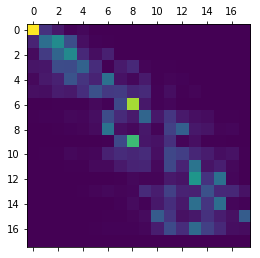

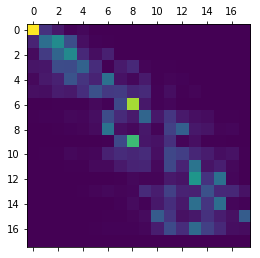

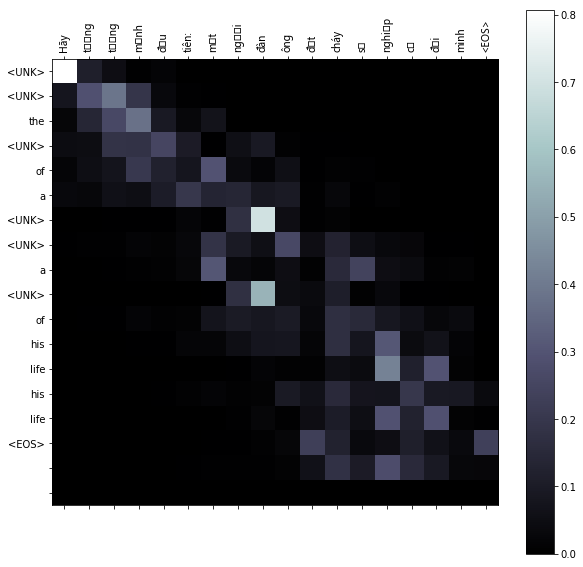

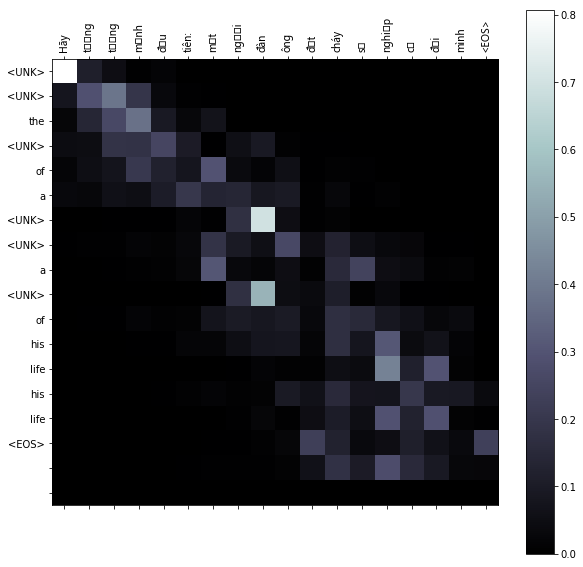

In [45]:
showAttention(source, decoded_words, decoder_attentions)

In [ ]:
# encoder.load_state_dict(torch.load('./model/encoder_3.pth'))
# decoder.load_state_dict(torch.load('./model/encoder_3.pth'))

In [47]:
val_dataset2 = LanguageDataset(val_zh_indicies, val_en_indicies)
val_loader2 = torch.utils.data.DataLoader(dataset=val_dataset2,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

decoded_words = evaluate_beam(encoder, decoder, val_loader2, beam_size=2, max_length=MAX_SENTENCE_LENGTH)
output_words, input_words, target_words, score= evaluate2(encoder, decoder, val_loader)

NameError: name 'evaluate_beam' is not defined

NameError: name 'evaluate_beam' is not defined

In [46]:
output_words, input_words, target_words, score= evaluate2(encoder, decoder, val_loader)
output_words, input_words, target_words, score= evaluate2(encoder, decoder, test_loader)
#output_words, input_words, target_words, score= evaluate2(encoder, decoder, train_loader)

bleu score:  25.509098833821298
bleu score:  25.509098833821298
bleu score:  24.771743643681983
bleu score:  24.771743643681983


In [ ]:
output_words, input_words, target_words, score= evaluate2(encoder, decoder, val_loader)
output_words, input_words, target_words, score= evaluate2(encoder, decoder, test_loader)
#output_words, input_words, target_words, score= evaluate2(encoder, decoder, train_loader)

In [ ]:
for i in range(len(output_words)):
    print('input: ', input_words[i])
    print('target: ', target_words[i])
    print('predict: ', output_words[i])
    print('-----------------------------------------------')
    print()

In [48]:
class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_idx, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            return -100000
            #raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size):
        #topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_idx:
                terminates.append(([en_id2token[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) # tuple(word_list, score_float
                continue
            idxes = self.sentence_idxes[:] # pass by value
            scores = self.sentence_scores[:] # pass by value
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self):
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_idx:
                words.append('<EOS>')
            else:
                words.append(en_id2token[self.sentence_idxes[i].item()])
        if self.sentence_idxes[-1] != EOS_idx:
            words.append('<EOS>')
        return (words, self.avgScore())

def beam_decode(decoder, decoder_hidden, encoder_outputs, beam_size, cur_batch_size, max_length=MAX_SENTENCE_LENGTH):
    terminal_sentences, prev_top_sentences, next_top_sentences = [], [], []
    prev_top_sentences.append(Sentence(decoder_hidden))
    for i in range(max_length):
        for sentence in prev_top_sentences:
            decoder_input = torch.tensor(np.array([[sentence.last_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
            #decoder_input = torch.LongTensor([[sentence.last_idx]])
            #decoder_input = decoder_input.to(device)
            decoder_hidden = sentence.decoder_hidden
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(beam_size)
            term, top = sentence.addTopk(topi, topv, decoder_hidden, beam_size)
            terminal_sentences.extend(term)
            next_top_sentences.extend(top)

        next_top_sentences.sort(key=lambda s: s.avgScore(), reverse=True)
        prev_top_sentences = next_top_sentences[:beam_size]
        next_top_sentences = []

    terminal_sentences += [sentence.toWordScore() for sentence in prev_top_sentences]
    terminal_sentences.sort(key=lambda x: x[1], reverse=True)
    n = 1
    return terminal_sentences[:1]

def evaluate_beam(encoder, decoder, loader, beam_size, max_length=MAX_SENTENCE_LENGTH):
    encoder.eval()
    decoder.eval()
    input_words = []
    target_words = []
    decoded_words = []
    num_count = 0
    for i, (source, translate) in enumerate(loader):
        cur_batch_size = translate.size()[0]
        with torch.no_grad():
            encoder_hidden = encoder.init_hidden(cur_batch_size)
            
        for i in range(cur_batch_size):
            input_words.append([])
            target_words.append([])
        
        for i in range(cur_batch_size):
            for ii in range(source.size()[1]):
                if zh_id2token[source.cpu().numpy()[i,ii]] != '<PAD>':
                    input_words[num_count].append(zh_id2token[source.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size
        for i in range(cur_batch_size):
            for ii in range(translate.size()[1]):
                if en_id2token[translate.cpu().numpy()[i,ii]] != '<PAD>':
                    target_words[num_count].append(en_id2token[translate.cpu().numpy()[i,ii]])
            num_count += 1
        
        encoder_outputs, encoder_hidden = encoder(source, encoder_hidden)
        
        decoder_hidden = encoder_hidden
        
        decoded_words.append(beam_decode(decoder, decoder_hidden, encoder_outputs, beam_size, cur_batch_size))
        
    pre_list = []
    for i in range(len(decoded_words)):
        pre_list.append("".join([" "+ i if not i.startswith("'") and i not in string.punctuation else i for i in decoded_words[i][0][0]]).strip())
    
    true_list = []
    for true_sentenc in target_words:
        true_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in true_sentenc]).strip())
    
    score = sacrebleu.corpus_bleu(pre_list, [true_list])
    print('bleu score: ', score.score)
    
    return decoded_words, target_words, score

In [49]:
val_dataset2 = LanguageDataset(val_zh_indicies, val_en_indicies)
val_loader2 = torch.utils.data.DataLoader(dataset=val_dataset2,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
test_dataset2 = LanguageDataset(test_zh_indicies, test_en_indicies)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
decoded_words1 = evaluate_beam(encoder, decoder, test_loader2, beam_size=2, max_length=MAX_SENTENCE_LENGTH)
#output_words, input_words, target_words, score= evaluate2(encoder, decoder, val_loader)

bleu score:  25.798273814393966
bleu score:  25.798273814393966


In [ ]:
del decoded_words1

In [ ]:
decoded_words2 = evaluate_beam(encoder, decoder, test_loader2, beam_size=3, max_length=MAX_SENTENCE_LENGTH)
# output_words, input_words, target_words, score= evaluate2(encoder, decoder, val_loader)